In [2]:
!python main.py --dataset MSL --model Encoded-IF --max_epoch 0

GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-480b86ce-82c7-48b7-a7dd-fc17ae650136)

available datasets : 
['SMAP', 'MSL', 'SMD', 'machine-1-1', 'machine-1-2', 'machine-1-3', 'machine-1-4', 'machine-1-5', 'machine-1-6', 'machine-1-7', 'machine-1-8', 'machine-2-1', 'machine-2-2', 'machine-2-3', 'machine-2-4', 'machine-2-5', 'machine-2-6', 'machine-2-7', 'machine-2-8', 'machine-2-9', 'machine-3-1', 'machine-3-2', 'machine-3-3', 'machine-3-4', 'machine-3-5', 'machine-3-6', 'machine-3-7', 'machine-3-8', 'machine-3-9', 'machine-3-10', 'machine-3-11'] 

available model : 
['IF', 'USAD', 'Encoded-IF'] 

available max_epoch : 
[int_value > 0] 


--- Configurations ---
 'batch_size': 942,
 'dataset': 'MSL',
 'initial_lr': 0.0001,
 'max_epoch': 1,
 'max_test_size': None,
 'max_train_size': None,
 'model_name': 'Encoded-IF',
 'test_start': 0,
 'train_start': 0,
 'window_length': 5,
 'x_dim': 55,
 'z_dim': 33


load data of: MSL
Train  Data normalized
Test  Data normalized
train set shape:  (58317, 55

In [37]:
import os
import random
import pickle
import sys
import time
import warnings
import argparse
from pprint import pformat, pprint
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data_utils

warnings.filterwarnings('ignore')

seed = 42

# seed fixed : for replaying experiments
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)  
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    np.random.seed(seed)

seed_everything(seed) 

from utils import *
import models.IF_Encoder as if_encoder
from models.IF_Encoder import IF_Encoder
import models.USAD as usad
from models.USAD import USAD

from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

nvidia = subprocess.check_output(["nvidia-smi", "-L"], text=True)
print(f'{nvidia}')

device = get_default_device()

GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-480b86ce-82c7-48b7-a7dd-fc17ae650136)



In [38]:
# parse the arguments
parser = argparse.ArgumentParser()

group_indexs = [range(1, 9), range(1, 10), range(1, 12)]

SMD = ['SMD']
for group in group_indexs:
    for idx in group:
        SMD.append('machine-' + str(group_indexs.index(group) + 1) + '-' + str(idx))
del group_indexs
        
dataset_name = ['SMAP', 'MSL'] + SMD
parser.add_argument('--dataset', type=str, help='dataset_name', default='MSL', choices=dataset_name)
parser.add_argument('--model', type=str, default='Encoded-IF', choices=['IF', 'USAD', 'Encoded-IF'])
parser.add_argument('--max_epoch', type=int, default=0)

print(f'available datasets : \n{dataset_name} \n')
print('available model : \n[\'IF\', \'USAD\', \'Encoded-IF\'] \n')
print('available max_epoch : \n[int_value > 0] \n')

args = None
for argv in sys.argv:
    if '--' in argv:
        args = parser.parse_args()
        break
if args == None:
    args = parser.parse_args(['--dataset', 'MSL', '--model', 'Encoded-IF', '--max_epoch', '0'])    

available datasets : 
['SMAP', 'MSL', 'SMD', 'machine-1-1', 'machine-1-2', 'machine-1-3', 'machine-1-4', 'machine-1-5', 'machine-1-6', 'machine-1-7', 'machine-1-8', 'machine-2-1', 'machine-2-2', 'machine-2-3', 'machine-2-4', 'machine-2-5', 'machine-2-6', 'machine-2-7', 'machine-2-8', 'machine-2-9', 'machine-3-1', 'machine-3-2', 'machine-3-3', 'machine-3-4', 'machine-3-5', 'machine-3-6', 'machine-3-7', 'machine-3-8', 'machine-3-9', 'machine-3-10', 'machine-3-11'] 

available model : 
['IF', 'USAD', 'Encoded-IF'] 

available max_epoch : 
[int_value > 0] 



In [39]:
class ExpConfig():
    model_name = args.model
    dataset = args.dataset
    x_dim = get_data_dim(dataset)
    z_dim = 38
    window_length = 5
    max_epoch =  args.max_epoch
    batch_size = 455
    optimizer = torch.optim.AdamW
    initial_lr = 1e-4
    
    train_start = 0
    max_train_size = None  # `None` means full train set
    test_start = 0
    max_test_size = None  # `None` means full test set

if __name__ == '__main__':
    USAD_SMD_bestEpoch = {
        0:15,
        1:20,
        2:15,
        3:20,
        4:15,
        5:15,
        6:20,
        7:15,
        8:15,
        9:15,
        10:15,
        11:15,
        12:25,
        13:15,
        14:15,
        15:15,
        16:15,
        17:15,
        18:15,
        19:15,
        20:15,
        21:15,
        22:15,
        23:10,
        24:15,
        25:15,
        26:15,
        27:15,
        28:25
                       }
    
    IF_Encoder_SMD_bestEpoch = {
            0:60,
            1:90,
            2:90,
            3:90,
            4:90,
            5:95,
            6:65,
            7:70,
            8:70,
            9:85,
            10:80,
            11:80,
            12:90,
            13:85,
            14:90,
            15:80,
            16:90,
            17:70,
            18:90,
            19:90,
            20:90,
            21:90,
            22:90,
            23:150,
            24:90,
            25:90,
            26:90,
            27:55,
            28:90
                        }

    # get config obj
    config = ExpConfig()

    if config.dataset in SMD:
        idx = SMD.index(config.dataset)
        config.z_dim = 38
        if config.model_name == "Encoded=IF" and config.max_epoch == 0:
            config.max_epoch = IF_Encoder_SMD_bestEpoch[idx]
        elif config.model_name == "USAD" and config.max_epoch == 0:
            config.max_epoch = USAD_SMD_bestEpoch[idx]
        config.batch_size = 455
    elif config.dataset == "SMAP":
        config.z_dim = 55
        if config.model_name == "Encoded-IF" and config.max_epoch == 0:
            config.max_epoch = 135
        elif config.model_name == "USAD" and config.max_epoch == 0:
            config.max_epoch = 20
        config.batch_size = 1804
    elif config.dataset == "MSL":
        config.z_dim = 33
        if config.model_name == "Encoded-IF" and config.max_epoch == 0:
            config.max_epoch = 70
        elif config.model_name == "USAD" and config.max_epoch == 0:
            config.max_epoch = 20
        config.batch_size = 942

    params = {param:getattr(config, param) for param in dir(config) if not callable(getattr(config, param)) and not param.startswith("__")}
    msg = ['\n--- Configurations ---', pformat(params).replace('{', ' ').split('}')[0], '\n']
    print(*msg, sep='\n')


--- Configurations ---
 'batch_size': 942,
 'dataset': 'MSL',
 'initial_lr': 0.0001,
 'max_epoch': 70,
 'max_test_size': None,
 'max_train_size': None,
 'model_name': 'Encoded-IF',
 'test_start': 0,
 'train_start': 0,
 'window_length': 5,
 'x_dim': 55,
 'z_dim': 33




In [40]:
# windows
x_train = None
x_test = None
y_test = None

window_size = config.window_length
windows_normal = None
windows_attack = None
labels = None
if config.dataset != 'SMD':
    (x_train, _), (x_test, y_test) = get_data(config.dataset, config.max_train_size, config.max_test_size, train_start=config.train_start, test_start=config.test_start)
else:
    windows_normal = np.array([]).reshape(-1, window_size, config.x_dim)
    windows_attack = np.array([]).reshape(-1, window_size, config.x_dim) 
    labels = np.array([]).reshape(-1)    
    for dataset in SMD[1:]:
        (x_train_part, _), (x_test_part, y_test_part) = get_data(dataset, config.max_train_size, config.max_test_size, train_start=config.train_start, test_start=config.test_start)
        
        x_train_part = x_train_part.reshape(-1, config.x_dim)
        x_train = x_train_part[np.arange(window_size)[None, :] + np.arange(x_train_part.shape[0] - window_size)[:, None]]
        windows_normal = np.concatenate((windows_normal, x_train))
        
        x_test_part = x_test_part.reshape(-1, config.x_dim)
        x_test = x_test_part[np.arange(window_size)[None, :] + np.arange(x_test_part.shape[0] - window_size)[:, None]]
        windows_attack = np.concatenate((windows_attack, x_test))
        
        y_test_part = y_test_part.reshape(-1)
        windows_labels=[]
        for i in range(len(y_test_part)-window_size):
            windows_labels.append(list(np.int_(y_test_part[i:i+window_size])))
        y_test = np.array([-1 if (np.sum(window) > 0) else 1 for window in windows_labels ])
        labels = np.concatenate((labels, y_test))

contamination = None
if config.dataset != 'SMD':
    contamination = len(y_test[y_test == 1]) / len(y_test)
else:
    contamination = len(labels[labels == -1]) / len(labels)
print('anomalies: {:.4f}'.format(contamination))

if config.dataset != 'SMD':
    windows_normal = x_train[np.arange(window_size)[None, :] + np.arange(x_train.shape[0] - window_size)[:, None]]
print('train window shape: ', windows_normal.shape)

if config.dataset != 'SMD':
    windows_attack = x_test[np.arange(window_size)[None, :] + np.arange(x_test.shape[0] - window_size)[:, None]]
print('test window shape: ', windows_normal.shape)

load data of: MSL
Train  Data normalized
Test  Data normalized
train set shape:  (58317, 55)
test set shape:  (73729, 55)
test set label shape:  (73729,)
anomalies: 0.1053
train window shape:  (58312, 5, 55)
test window shape:  (58312, 5, 55)


In [41]:
# training
N_EPOCHS = config.max_epoch
BATCH_SIZE = config.batch_size
optimizer = config.optimizer # torch.optim.AdamW
lr = config.initial_lr
hidden_size = config.z_dim
 
w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = None
print('\ntrain start')
if config.model_name == "Encoded-IF":
    model = IF_Encoder(w_size)
    model = to_device(model,device)
    if_encoder.training(N_EPOCHS,model,train_loader,val_loader,opt_func=optimizer, lr=lr)
elif config.model_name == "USAD":
    model = USAD(w_size, z_size)
    model = to_device(model,device)
    usad.training(N_EPOCHS,model,train_loader,val_loader,opt_func=optimizer)
print('train end\n')
model = to_device(model,'cpu')


train start
Epoch [0], validation loss: 0.0146
Epoch [1], validation loss: 0.0114
Epoch [2], validation loss: 0.0092
Epoch [3], validation loss: 0.0077
Epoch [4], validation loss: 0.0067
Epoch [5], validation loss: 0.0060
Epoch [6], validation loss: 0.0055
Epoch [7], validation loss: 0.0053
Epoch [8], validation loss: 0.0052
Epoch [9], validation loss: 0.0051
Epoch [10], validation loss: 0.0050
Epoch [11], validation loss: 0.0050
Epoch [12], validation loss: 0.0050
Epoch [13], validation loss: 0.0050
Epoch [14], validation loss: 0.0050
Epoch [15], validation loss: 0.0049
Epoch [16], validation loss: 0.0049
Epoch [17], validation loss: 0.0049
Epoch [18], validation loss: 0.0048
Epoch [19], validation loss: 0.0048
Epoch [20], validation loss: 0.0048
Epoch [21], validation loss: 0.0047
Epoch [22], validation loss: 0.0047
Epoch [23], validation loss: 0.0046
Epoch [24], validation loss: 0.0045
Epoch [25], validation loss: 0.0045
Epoch [26], validation loss: 0.0044
Epoch [27], validation lo

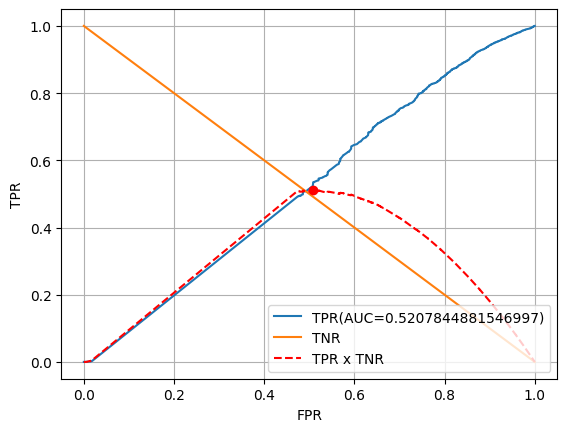

In [42]:
# testing
latent = None
X_train = None
if config.model_name == "Encoded-IF":
    latent = if_encoder.encoding(model, train_loader)
    latent = np.concatenate([torch.stack(latent[:-1]).flatten().detach().cpu().numpy(),
                              latent[-1].flatten().detach().cpu().numpy()]).reshape(-1, int(w_size * 0.05))
    X_train = torch.from_numpy(np.concatenate((windows_normal_train.reshape(-1,w_size), latent), axis=1))
elif config.model_name == "IF":
    X_train = torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))

IF = None
if "IF" in config.model_name:
    IF = IsolationForest(contamination=contamination, random_state=seed)  # 이상치 비율을 설정
    IF.fit(X_train)

model = to_device(model,'cpu')

latent = None
X_test = None
if config.model_name == "Encoded-IF":
    latent = if_encoder.encoding(model, test_loader)
    latent = np.concatenate([torch.stack(latent[:-1]).flatten().detach().cpu().numpy(),
                                  latent[-1].flatten().detach().cpu().numpy()]).reshape(-1,int(w_size * 0.05))
    X_test = torch.from_numpy(np.concatenate((windows_attack.reshape(-1,w_size), latent), axis=1))
elif config.model_name == "IF":
    X_test = torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))

# anomaly scoring
scores = None
if "IF" in config.model_name:
    scores = IF.decision_function(X_test)
elif config.model_name == "USAD":
    results = usad.testing(model,test_loader)
    scores = np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])
    scores = -scores
scores = (scores - np.min(scores) + 1e-8) / (np.max(scores) - np.min(scores) + 2 * 1e-8)
scores = (2 - 1e-8) * (scores - ((np.max(scores) - np.min(scores)) / 2))

if config.dataset != 'SMD':
    windows_labels=[]
    for i in range(len(y_test)-window_size):
        windows_labels.append(list(np.int_(y_test[i:i+window_size])))
    labels = np.array([-1 if (np.sum(window) > 0) else 1 for window in windows_labels])

threshold = ROC(labels,scores)

In [43]:
def calc_metrics(scores, labels, pos, best_threshold=None):
    best_precision = 0
    best_recall = 0
    best_f1_score = 0
    best_f1_star = 0

    if best_threshold == None:
        for threshold in np.linspace(np.min(scores), np.max(scores), num=100):
            predictions = np.where(scores > threshold, 1, -1)
            
            F1_Score = f1_score(labels, predictions, pos_label=pos)
            if F1_Score > best_f1_score:
                best_precision= precision_score(labels, predictions, pos_label=pos)
                best_recall = recall_score(labels, predictions, pos_label=pos)
                best_f1_score = F1_Score
                
                best_threshold = threshold
    else:
        predictions = np.where(scores > best_threshold, 1, -1)
        
        best_precision = precision_score(labels, predictions, pos_label=pos)
        best_recall = recall_score(labels, predictions, pos_label=pos)
        best_f1_score = f1_score(labels, predictions, pos_label=pos)        
    
    print("dectection precision: ", best_precision)
    print("dectection recall:    ", best_recall)
    print("dectection f1 score:  ", best_f1_score)
    print("dectection threshold: ", best_threshold)
    print()
    
    return best_threshold

# Evaluation
print('\nnormal dectection metrics:')
threshold = calc_metrics(scores=scores, labels=labels, pos=1, best_threshold=threshold)


normal dectection metrics:
dectection precision:  0.8964842240824211
dectection recall:     0.5288540432126904
dectection f1 score:   0.6652586511721252
dectection threshold:  0.7616511843785028



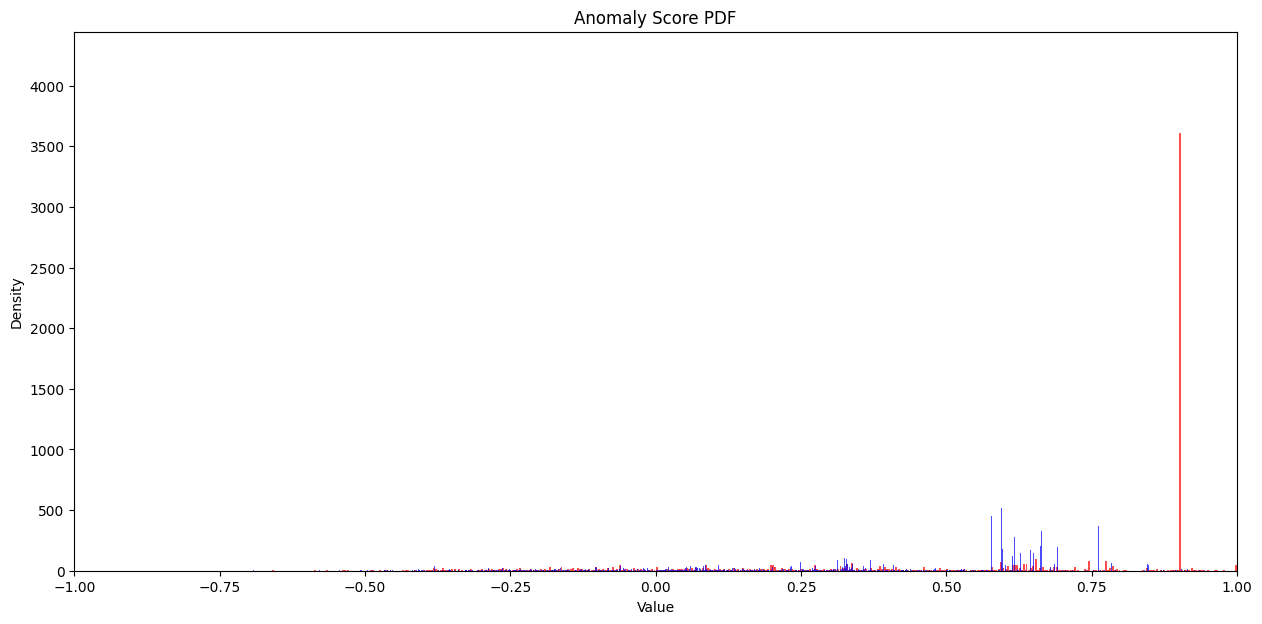

In [47]:
# Distribution
plt.figure(figsize=[15, 7])
plt.hist(scores[np.argwhere(labels == -1)], bins=500, density=False, alpha=0.7, rwidth=0.85, label='anomaly', color='red')
plt.hist(scores[np.argwhere(labels == 1)], bins=int(500 / contamination), density=False, alpha=0.7, rwidth=0.85, label='normal', color='blue')
plt.xlabel('Value')
plt.ylabel('Density')
plt.xlim(-1,1)
plt.ylim(0,4444)
plt.title('Anomaly Score PDF')
plt.show()